# Calling NucDiff
#### DATE: 02-08-19
#### TASK: 
####       - Call NucDiff on reference file (H37rv) and query file (M. orygis or M. bovis)
####       - Return relevent information in a dataframe

In [1]:
import os, sys, io, random, subprocess
import string
import numpy as np
import pandas as pd
pd.set_option('display.width',150)
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

sys.path.append('/home/tortoise/pybioviz/')
from pybioviz import viewers, utils

import seaborn as sns

In [2]:
# Here, a set of features are defined.
# These features are what shall be extracted from inputted gff files, and are used as column headers in the dataframe
# Many titles will return as NaN however allows merging of different features, such as SNPs and Insertions
featurekeys = ['ID', 'Name', 'del_len', 'ins_len', 'query_bases', 'ref_bases', 'query_coord', 'start', 'end']
def features_to_dataframe(features, cds=False):
    """Get features from a biopython seq record object into a dataframe
    Args:
        features: bio seqfeatures
       returns: a dataframe with a row for each cds/entry.
      """
    
    #preprocess features
    allfeat = []
    for (item, f) in enumerate(features):
        x = f.__dict__
        q = f.qualifiers
        #print(q)
        x.update(q)
        d = {}
        d['start'] = f.location.start
        d['end'] = f.location.end
        #d['strand'] = f.location.strand
        for i in featurekeys:
            if i in x:
                if type(x[i]) is list:
                    d[i] = x[i][0]
                else:
                    d[i] = x[i]
        allfeat.append(d)

    df = pd.DataFrame(allfeat,columns=featurekeys)

    return df

In [229]:

# Here, the reference and query genomes are defined. Would be the command line arguments

# Reference:
mtb = 'ref_genomes/MTB_h37rv.fna'
gff_file = 'MTB.gff'
# Query genomes:
mbovis = 'ref_genomes/mbovis.fna'
mafri = 'ref_genomes/mafricanum.fna'
mcan = 'ref_genomes/mcanettii.fna'
mcap = 'ref_genomes/mcap.fna'
mmic = 'ref_genomes/mmic.fna'
morygis_112400015 = 'ref_genomes/morygis-112400015.fna'
morygis_NIRTAH144 = 'ref_genomes/morygis-NIRTAH144.fna'
mpin = 'ref_genomes/mpin.fna'

# Here, the genomes are added to a list for function parsing
# Would be automated using "for arg in sys.argv" loop
genome_list = [mbovis, mafri, mcan, mcap, mmic, morygis_112400015, morygis_NIRTAH144, mpin]

In [17]:
# Here the previous test NucDiff test folder is removed

remove_test = 'rm -r MTB_h37rv_mbovis'
code = os.system(remove_test)
print(code)

0


Here the NucDiff command is defined. Currently, it is hardcoded, but sys.argv arguments will be written in.


In [99]:
def run_nucdiff(ref, query_list):
    """Run nucdiff"""
    
    # This list will catch the output file names for easier parsing
    outputfolder_list = []
    
    # The list of genomes is iterated over
    for query in query_list:
    
        #The output folder name is defined from the query name
        outfolder = os.path.basename(ref).split('.')[0] + '_' +  os.path.basename(query).split('.')[0]
        
        # The folder name is appended to the list
        # We include '/results' as these are the main dub folder of interest
        outputfolder_list.append(outfolder + '/results')
        
        #The output prefix name is defined from the query name
        outprefix = os.path.basename(query).split('.')[0]

        # The command is defined using nucdiff and the reference genome of MTB, the query genome
        # The command also uses the defined output file name and prefix name
        nucDiffCmd = f'nucdiff {ref} {query} {outfolder} {outprefix}'

        # The command used is printed to screen...
        print (nucDiffCmd)

        # .. and called
        os.system(nucDiffCmd)
    
    # The folder names are returned
    return outputfolder_list

# The list is passed into the nucdiff calling function
# The list of names of the folders containing the results are captured
nucdiff_results = run_nucdiff(mtb, genome_list)

nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/mbovis.fna MTB_h37rv_mbovis mbovis
nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/mafricanum.fna MTB_h37rv_mafricanum mafricanum
nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/mcanettii.fna MTB_h37rv_mcanettii mcanettii
nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/mcap.fna MTB_h37rv_mcap mcap
nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/mmic.fna MTB_h37rv_mmic mmic
nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/morygis-112400015.fna MTB_h37rv_morygis-112400015 morygis-112400015
nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/morygis-NIRTAH144.fna MTB_h37rv_morygis-NIRTAH144 morygis-NIRTAH144
nucdiff ref_genomes/MTB_h37rv.fna ref_genomes/mpin.fna MTB_h37rv_mpin mpin


## find common differences morygis and mbovis vs mtb

In [100]:
def features_to_dataframe(features, cds=False):
    """Get features from a biopython seq record object into a dataframe
    Args:
        features: bio seqfeatures
       returns: a dataframe with a row for each cds/entry.
      """

    #preprocess features
    allfeat = []
    for (item, f) in enumerate(features):
        x = f.__dict__
        quals = f.qualifiers
        #print(q)
        x.update(quals)
        d = {}
        d['start'] = f.location.start
        d['end'] = f.location.end
        #d['strand'] = f.location.strand
     
        cols = list(quals.keys())+['start','end']
        for i in quals:
            if i in x:
                if type(x[i]) is list:
                    d[i] = x[i][0]
                else:
                    d[i] = x[i]
        allfeat.append(d)

    df = pd.DataFrame(allfeat,columns=cols)

    return df

In [101]:
#read in both gffs from nucdiff

# This extracts the snps from the snps.gff file and returns a dataframe
def get_nucdiff_snps(gff):
    feats = utils.gff_to_features(gff)
    df = features_to_dataframe(feats)
    results_df = df[df.Name=='substitution']
    return results_df

# This extracts the indels from the structs.gff file and returns a dataframe 
def get_nucdiff_indels(gff):
    feats = utils.gff_to_features(gff)
    df = features_to_dataframe(feats)
                                #results_df = df[(df.Name=='deletion') | (df.Name=='insertion')]
    # It was chosen to return all features, not just indels
    return df


In [102]:
# These lists are defined to catch each struct/snps results df for each file
# Each list of dfs is then concated into one df each for all structs and all snps
indels_list = []
snps_list = []

# We iterate over the results file and extract features
for result_file in nucdiff_results:
    
    # We then iterate over each file in the results..
    for result in os.listdir(result_file):
        
            # .. and only parse the files of interest..
            # Here snp results are viewed, and below structural results are viewed
            if "ref_snps" in result:
                
                # A df is made from the snps.gff file, capturing all features
                snps_df = get_nucdiff_snps(f'{result_file}/{result}')
                
                # The df then has a column added, stating which species it came from, for use in the final df
                snps_df['Species'] = result.split('_')[0]
                
                # The resulting df is then added to the list of dfs, later concated into one df
                snps_list.append(snps_df)

            # The same is done for structural differences as was done for snps
            if "ref_struct" in result:
            
                indels_df = get_nucdiff_indels(f'{result_file}/{result}')
                indels_df['Species'] = result.split('_')[0]
                indels_list.append(indels_df)
                
            
indels = pd.concat(indels_list, sort=True)
snps = pd.concat(snps_list, sort=True)

In [205]:
indels.Species.unique()

array(['mbovis', 'mafricanum', 'mcanettii', 'mcap', 'mmic',
       'morygis-112400015', 'morygis-NIRTAH144', 'mpin'], dtype=object)

In [224]:
# Here, only the insertions and deletions are extracted from the structural differences
indels_only = indels[(indels.Name == 'deletion') | (indels.Name == 'insertion')]

# A pivot table is then made from the indels
# Here, the columns and rows are rearranged, with each indel being grouped by their start position
# This puts together common points of insertion/deltion in each species
# Non-present locations (fill_value) are given a '0'...
start_table = pd.pivot_table(indels, index=['start'], columns=['Species'], aggfunc=np.sum, fill_value = 0)

# ... and present values are given a '1'
start_table[start_table > 1] = 1

# Here we put just mbovis and morygis into a DF
mor_mbo = start_table.end.drop(['mcap', 'mpin', 'mcanettii', 'mafricanum', 'mmic'], axis = 1)
mor_mbo = mor_mbo[mor_mbo.sum(1)>0]

# This line only views indels present in more than one species
start_table = start_table[start_table.sum(1)>1]
start_table = start_table.end

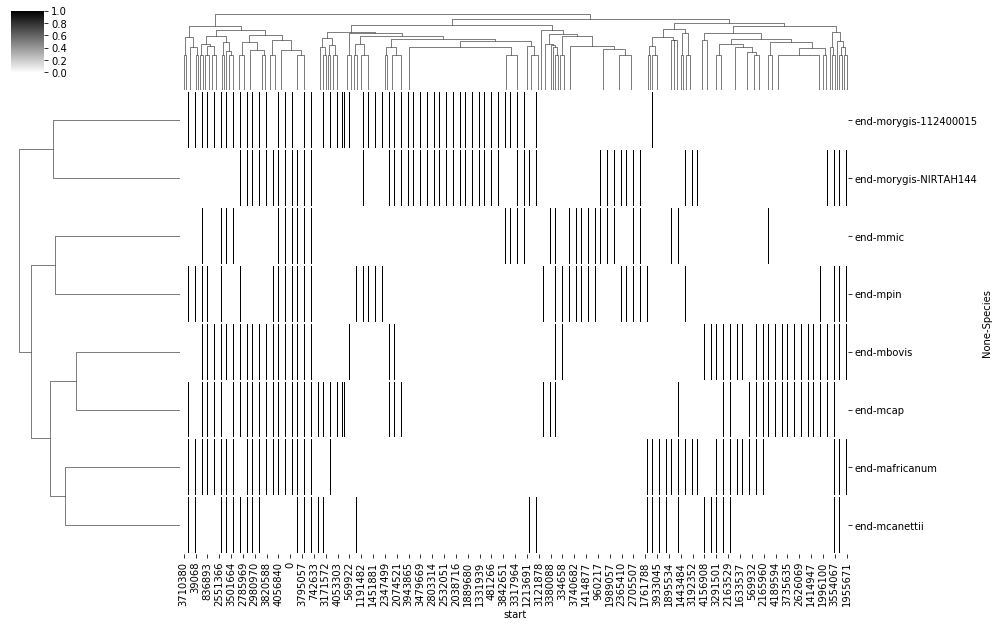

In [107]:
# Here a clustermap is made

g=sns.clustermap(start_table.T, figsize=(15,10), cmap="gray_r", lw=1)
g.savefig('clustermap.png',dpi=150)

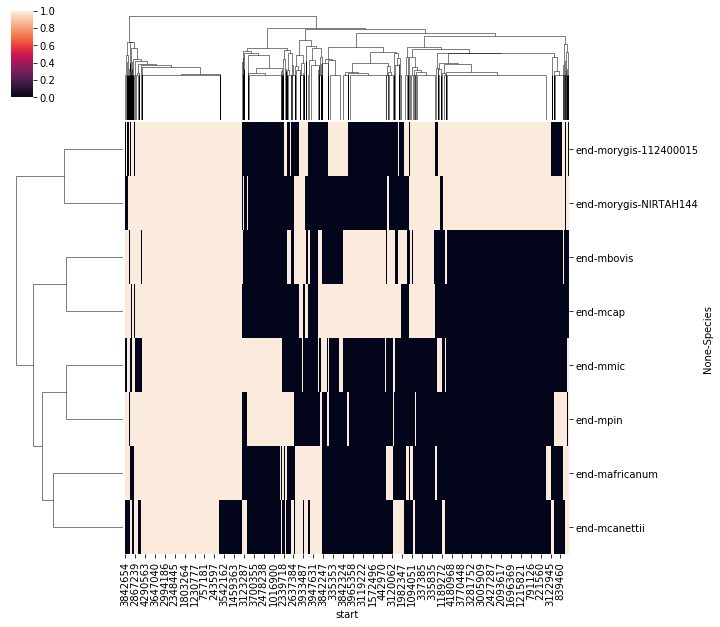

In [132]:
# The above is then repeated for snps
snp_start_table = pd.pivot_table(snps, index=['start'], columns=['Species'], aggfunc=np.sum, fill_value = 0)
snp_start_table[snp_start_table > 1] = 1
snp_start_table = snp_start_table[snp_start_table.sum(1)>1]
#snp_start_table = snp_start_table[snp_start_table.sum(1)<5]

# A cluster map is then made using the SNPs
sns.clustermap(snp_start_table.T)

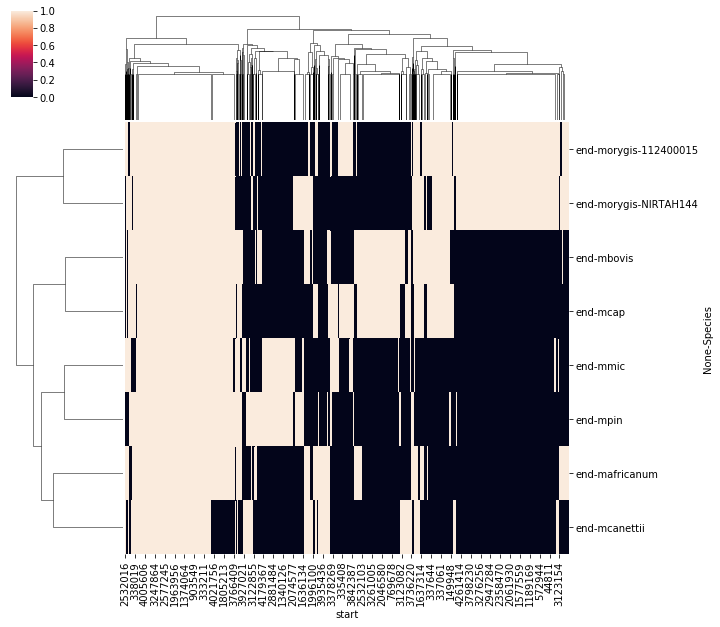

In [109]:
snps_indels_start_table = pd.concat([start_table, snp_start_table])
snps_indels_start_table
sns.clustermap(snps_indels_start_table.T)

In [235]:
intersection = mor_mbo[mor_mbo.sum(1)==3]
union = mor_mbo[mor_mbo.sum(1)>0]
only_in_bovis = mor_mbo[(mor_mbo.mbovis == 1) & (mor_mbo.sum(1) == 1)]
only_in_both_orygis = mor_mbo[(mor_mbo.mbovis == 0) & (mor_mbo.sum(1) == 2)]
only_in_one_morygis_strain = mor_mbo[(mor_mbo.mbovis == 0) & (mor_mbo.sum(1) == 1)]
bovis_1124 = mor_mbo[(mor_mbo.mbovis == 1) & (mor_mbo['morygis-112400015'] == 1)]
bovis_NIRT = mor_mbo[(mor_mbo.mbovis == 1) & (mor_mbo['morygis-NIRTAH144'] == 1)]

#print(f'total:{len(mor_mbo)}\nunion:{len(union)}\nintersection:{len(intersection)}\nindels only in mbovis:{len(only_in_bovis)}\
#\nindels only in both morygis:{len(only_in_both_orygis)}\nindels only in one morygis:{len(only_in_one_morygis_strain)}')

Species,mbovis,morygis-112400015,morygis-NIRTAH144
start,,,
0,1,1,1
150902,1,1,1
264754,1,1,1
362807,1,1,1
623296,1,1,1
742633,1,1,1
836872,1,1,1
1213691,1,1,1
1443484,1,1,1


In [281]:
########################################################## feats had an entry at the very start stretching the entire genome
#                                                          and was annotated as NaN, which was being assigned

feats = utils.gff_to_features(gff_file)
feats = features_to_dataframe(feats)
print(feats[0:1])

def get_site_annotations(x):
    f = feats[((x.start>=feats.start) & (x.start<=feats.end)) |
                  ((x.end>=feats.start) & (x.end<=feats.end)) |
                  ((x.start<=feats.start) & (x.end>=feats.end))]
    if len(f)>0:
        return f.iloc[0].Name
     
feats = feats.drop([0], axis=0)    
indels['gene'] = indels.apply(get_site_annotations, 1)
print (indels[cols][:65])


    ID       Dbxref Name gbkey gene gene_biotype locus_tag  source  start      end
0  id0  taxon:83332  NaN   Src  NaN          NaN       NaN  RefSeq      0  4411532
         ID                     Name Species    start      end       gene
0      SV_1  reshuffling-part_1_gr_0  mbovis        0   334658       dnaA
1      SV_2                insertion  mbovis    71585    71586       None
2      SV_3              duplication  mbovis    71585    71586       None
3      SV_4                insertion  mbovis   150902   150903   PE_PGRS2
4      SV_5              duplication  mbovis   150902   150903   PE_PGRS2
5      SV_6                 deletion  mbovis   264754   266656     Rv0221
6      SV_8                insertion  mbovis   334657   334658    Rv0278c
7      SV_7                 deletion  mbovis   334658   335033    Rv0278c
8     SV_10  reshuffling-part_2_gr_0  mbovis   335033   335602    Rv0278c
9     SV_11                insertion  mbovis   335601   335602    Rv0278c
10     SV_9  reshuff

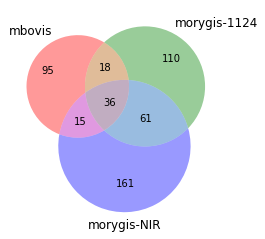

In [282]:
from matplotlib_venn import venn3

mbo = indels[indels.Species =='mbovis']
mor_1124 = indels[indels.Species =='morygis-112400015']
mor_NIR = indels[indels.Species =='morygis-NIRTAH144']

venn3((set(mbo.start), set(mor_1124.start), set(mor_NIR.start)), set_labels = ('mbovis', 'morygis-1124', 'morygis-NIR'))

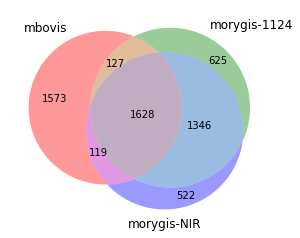

In [225]:
mbo = snps[snps.Species =='mbovis']
mor_1124 = snps[snps.Species =='morygis-112400015']
mor_NIR = snps[snps.Species =='morygis-NIRTAH144']

venn3((set(mbo.start), set(mor_1124.start), set(mor_NIR.start)), set_labels = ('mbovis', 'morygis-1124', 'morygis-NIR'))

In [283]:
common = mbo[mbo.start.isin(intersection.index)]
common.gene.unique()
common.columns
cols=['ID', 'Name', 'Species','start','end','gene']
common[cols]

,ID,Name,Species,start,end,gene
0,SV_1,reshuffling-part_1_gr_0,mbovis,0,334658,dnaA
3,SV_4,insertion,mbovis,150902,150903,PE_PGRS2
4,SV_5,duplication,mbovis,150902,150903,PE_PGRS2
5,SV_6,deletion,mbovis,264754,266656,Rv0221
12,SV_13,insertion,mbovis,362807,362808,PE_PGRS5
13,SV_14,duplication,mbovis,362807,362808,PE_PGRS5
17,SV_18,insertion,mbovis,623296,623297,PE_PGRS6
18,SV_19,duplication,mbovis,623296,623297,PE_PGRS6
19,SV_20,insertion,mbovis,742633,742634,None
21,SV_22,deletion,mbovis,836872,836893,PE_PGRS9


In [ ]:
# This forms a combined snps and indels df for each strain            
mbovis_snpdels = pd.concat([mbovis_indels_df, mbovis_snps_df])
morygis_snpdels = pd.concat([morygis_indels_df, morygis_snps_df])

#common_differences = pd.merge(mbovis_snpdels, morygis_snpdels, on=['start', 'end'], how='inner')
#common_differences = common_differences.drop(columns=['ID_x', 'ID_y', 'query_coord_y', 'query_coord_x'])

common_indels = pd.merge(mbovis_indels_df, morygis_indels_df, on=['start', 'end'], how='inner').drop(columns=['ID_x',
                                                                    'ID_y', 'query_coord_y', 'query_coord_x', 'source_x', 'source_y', 
                                                                    'query_sequence_y', 'query_sequence_x', 
                                                                        'query_dir', 'color_y', 'color_x', 'Name_y'])
common_indels.rename(columns={'Name_x':'Name'}, inplace=True)
print(common_indels[15:25])
#merge them on start position

In [8]:
# Here the RD df is read in

def find_regions(data):
    """match regions of difference"""
    
    RD = pd.read_csv('RD.csv', comment='#')
    found=[]
    print (len(data))
    for i,r in data.iterrows():
        df = RD[((r.start>RD.Start) & (r.start<RD.Stop)) |
                  ((r.end>RD.Start) & (r.end<RD.Stop)) |
                  ((r.start<RD.Start) & (r.end>RD.Stop))]
        #df = RD[abs(RD.Start-r.start)<500]
        if len(df) > 0:
            #print (df)
            #print (r)
            df['indel_start'] = r.start
            df['indel_end'] = r.end
            df['name'] = r.Name
            df['del_len'] = r.end-r.start
            found.append(df)

    found = pd.concat(found)
    return found

mb = find_regions(mbovis_indels_df)
mo = find_regions(morygis_indels_df)
mbmo = find_regions(common_indels)

print (len(mb),len(mo))

189


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

314
66
32 31


In [9]:
set(mb.RD_name) & set(mo.RD_name)

{'RD10', 'RD11', 'RD14', 'RD182', 'RD207', 'RD5', 'RD7', 'RD8', 'RD9'}

In [10]:
mb.sort_values('del_len')

,RD_name,Start,Stop,Size,Rv,indel_start,indel_end,name,del_len
27,RD7,2207700,2220800,13100,Rv1964-Rv1977,2208004,2208005,relocation,1
32,RD12,3484809,3487711,2902,SseC-Rv3121,3487514,3487515,collapsed_repeat,1
8,RD207,3120521,3127920,7400,Rv2814c-2820c,3122405,3122406,tandem_duplication,1
29,RD9,2328974,2332879,3905,CobL-Rv2075,2332101,2332102,collapsed_repeat,1
27,RD7,2207700,2220800,13100,Rv1964-Rv1977,2220724,2220725,relocation,1
24,RD4,1695281,1708539,13258,Rv1505c-Rv1516c,1696015,1696016,relocation,1
28,RD8,4057733,4063249,5516,EphA-lpqG,4062733,4062734,collapsed_repeat,1
25,RD5,2625888,2635592,9704,Rv2346c-Rv2353c,2635030,2635032,collapsed_repeat,2
12,RD182,2545194,2551674,6481,Rv2270-2280,2551366,2551371,collapsed_repeat,5
33,RD13,1402778,1406084,3306,Rv1255c-Rv1257c,1405937,1405944,collapsed_repeat,7


In [11]:
#RD5:   NC_000962.3:2,625,888-2,635,592  Similar         (Not flagged as same)
#RD10:  NC_000962.3:264,067-267,764      Common
#RD9:   NC_000962.3:2,328,974-2,332,879  Common
#RD8    NC_000962.3:4,053,166-4,066,581  Common

In [12]:
mbmo

,RD_name,Start,Stop,Size,Rv,indel_start,indel_end,name,del_len
30,RD10,264067,267764,3697,Rv0221-Rv0223,264754,266656,deletion,1902
27,RD7,2207700,2220800,13100,Rv1964-Rv1977,2208004,2208005,relocation,1
27,RD7,2207700,2220800,13100,Rv1964-Rv1977,2220724,2220725,relocation,1
29,RD9,2328974,2332879,3905,CobL-Rv2075,2330073,2332101,deletion,2028
28,RD8,4057733,4063249,5516,EphA-lpqG,4056840,4062733,deletion,5893
